In [7]:
import pandas as pd
import numpy as np
from copy import deepcopy
import os
import sys
import glob
import pathlib
import warnings
warnings.filterwarnings("ignore")

from sklearn import preprocessing

In [8]:
dfs = {}
symbols = []
future_list = glob.glob("D:/quant/data/futures/*")
future_list = sorted(future_list, key = lambda x: pathlib.Path(x).name[:-4].split(".")[-1])
for i in future_list:
    symbol = pathlib.Path(i).name[:-4]
    # if symbol == "AU0.shfe":
    df = pd.read_csv(i)
    if df.shape[0] > 100:
        dfs[symbol] = df
        symbols.append(symbol)
    # break

In [73]:
def get_raw_feature_df(df):
    # volume check
    volume_mean, volume_std = df["volume"].mean(), df["volume"].std()
    df = df[~((df["volume"] > (volume_mean+3*volume_std))
              | (df["volume"] < -(volume_mean+3*volume_std)))].reset_index(drop=True)
    
    datetime = df["datetime"]
    
    df = df.drop(["datetime","volume"], axis=1)
    df = (df-df.min())/(df.max()-df.min())
    
    df["datetime"] = datetime
    df["label"] = np.hstack([df["close"].values[1:], [0]]) 
    
    error_index = np.where(df["label"].values == np.inf)
    print(error_index)
    df = df.drop(error_index[0], axis=0).reset_index(drop=True)
    df = df.dropna().reset_index(drop=True)
    df = df.drop(0, axis=0).reset_index(drop=True)
    df = df.drop([len(df)-1], axis=0).reset_index(drop=True)
    return df

def get_feature_df(df):
    # volume check
    # volume_mean, volume_std = df["volume"].mean(), df["volume"].std()
    # df = df[~((df["volume"] > (volume_mean+3*volume_std))
    #           | (df["volume"] < -(volume_mean+3*volume_std)))].reset_index(drop=True)
    # volume_change = df.loc[1:,"volume"].values - df.loc[:(df.shape[0]-2),"volume"].values
    # volume_change_rate = volume_change / df.loc[:(df.shape[0]-2),"volume"].values * 100
    # df["volume_change"] = np.hstack([[0], volume_change_rate])
    # df = df[~((df["volume_change"] > 300) | (df["volume_change"] < -300))].reset_index(drop=True)

    error_index = np.where(df["close"].values == np.inf)
    df = df.drop(error_index[0], axis=0).reset_index(drop=True)
    error_index = np.where(df["open"].values == np.inf)
    df = df.drop(error_index[0], axis=0).reset_index(drop=True)
    
    def get_change(df, base="open"):
        base_change = df.loc[1:,base].values - df.loc[:(df.shape[0]-2),base].values
        base_change_rate = base_change / df.loc[:(df.shape[0]-2),base].values*100
        return np.hstack([[0], base_change_rate])

    for col in ["close"]: # ,"open","high","low"
        df[col+"_change"] = get_change(df, base=col)

    # open 相对前日 close
    # open_close_change = df.loc[1:,"open"].values - df.loc[:(df.shape[0]-2),"close"].values
    # open_close_change_rate = open_close_change / df.loc[:(df.shape[0]-2),"close"].values * 100
    # df["open_close_change"] = np.hstack([[0], open_close_change_rate])

    # 当日：开盘 收盘 最高 最低 差值 波动, 以开盘价和收盘价为基准
    # df["high_open_rate"] = (df["high"] - df["open"]) / df["open"] * 100
    # df["low_open_rate"] = (df["low"] - df["open"]) / df["open"] * 100
    # df["close_open_rate"] = (df["close"] - df["open"]) / df["open"] * 100
    # df["high_close_rate"] = (df["high"] - df["close"]) / df["close"] * 100
    # df["low_close_rate"] = (df["low"] - df["close"]) / df["close"] * 100
    # label = np.hstack([df["close_open_rate"].values[1:], [0]])
    # labels = []
    # for cc,co in zip(np.hstack([df["close_change"].values[1:], [0]]),
    #                  np.hstack([df["close_open_rate"].values[1:], [0]])):
    #     if cc > 0 and co > 0:
    #         label = 1
    #     else:
    #         label = 0
    #     labels.append(label)
    
    datetime = df["datetime"]
    df = df.drop(["datetime"], axis=1)
    df = (df-df.min())/(df.max()-df.min()) + 10
    df["datetime"] = datetime
    
    # df["label"] = labels
    df["label"] = np.hstack([df["close_change"].values[1:], [0]]) 

    df = df.drop(0, axis=0).reset_index(drop=True)
    df = df.drop([len(df)-1], axis=0).reset_index(drop=True)

    df = df.dropna().reset_index(drop=True)
    df = df.drop(["open","high","low","close","volume"], axis=1)
    return df

def split_sequences(df, window=30, step=1, train=True):
    X,y = [],[]
    for i in range(0, df.shape[0]-window-1, step):
        X.append(df.drop("label",axis=1).iloc[i:window+i,:].values)
        y.append(df.loc[i+window-1,"label"])

    return np.array(X), np.array(y)
    

from functools import reduce
def vstack_array(arrays):
    return reduce(lambda x, y: np.vstack([x,y]), arrays)
def hstack_array(arrays):
    return reduce(lambda x, y: np.hstack([x,y]), arrays)

In [68]:
window = 30

In [74]:
train_X, train_Y, valid_X, valid_Y, test_X, test_Y = [],[],[],[],[],[]
# for i,df in enumerate(dfs.values()):
df = dfs["AU0.shfe"]
# df = get_raw_feature_df(deepcopy(df)) 
df =  get_feature_df(deepcopy(df))
train_df = df[df["datetime"] < '2021-07-01'].reset_index(drop=True)
valid_df = df[(df["datetime"] > "2021-07-01") & (df["datetime"] < "2022-01-01")].reset_index(drop=True)
test_df = df[df["datetime"] > "2022-01-01"].reset_index(drop=True)

train_x, train_y = split_sequences(df=train_df.drop(["datetime"], axis=1), window=window, train=True)
valid_x, valid_y = split_sequences(df=valid_df.drop(["datetime"], axis=1), window=window)
test_x, test_y = split_sequences(df=test_df.drop(["datetime"], axis=1), window=window)

if len(train_y) > 0:
    train_X.append(train_x)
    train_Y.append(train_y)
if len(valid_y) > 0:
    valid_X.append(valid_x)
    valid_Y.append(valid_y)
if len(test_y) > 0:
    test_X.append(test_x)
    test_Y.append(test_y)

# break
    

if len(train_Y) > 1:
    train_data, valid_data, test_data = (
                (vstack_array(train_X), hstack_array(train_Y)),
                (vstack_array(valid_X), hstack_array(valid_Y)),
                (vstack_array(test_X), hstack_array(test_Y)),
            )
else:
    train_data, valid_data, test_data = (
                (np.array(train_X[0]), np.array(train_Y[0])),
                (np.array(valid_X[0]), np.array(valid_Y[0])),
                (np.array(test_X[0]), np.array(test_Y[0])),
            )
    
print(len(train_data[0]), len(valid_data[0]), len(test_data[0]), train_data[0].shape)

(array([], dtype=int64),)
2701 93 107 (2701, 30, 4)


In [75]:
sys.path.append("D:/quant")
from models import LSTM, ALSTM, TCN

model = LSTM(
    d_feat=train_data[0].shape[2],
    hidden_size=8,
    batch_size=32,
    loss='mse',
    lr=0.001,
    log_level="info",
)
model.fit(train_data,
        valid_data,
        save_path="D:/quant/checkpoint/model.pt")

preds = model.predict(test_data[0])
print(preds.shape)

2022-08-29 23:51:10,151 - lstm.py[line:58] - INFO: LSTM pytorch version...
2022-08-29 23:51:10,151 - lstm.py[line:58] - INFO: LSTM pytorch version...
2022-08-29 23:51:10,151 - lstm.py[line:58] - INFO: LSTM pytorch version...
2022-08-29 23:51:10,151 - lstm.py[line:58] - INFO: LSTM pytorch version...
2022-08-29 23:51:10,151 - lstm.py[line:58] - INFO: LSTM pytorch version...
2022-08-29 23:51:10,151 - lstm.py[line:58] - INFO: LSTM pytorch version...
2022-08-29 23:51:10,151 - lstm.py[line:58] - INFO: LSTM pytorch version...
2022-08-29 23:51:10,157 - lstm.py[line:75] - INFO: LSTM parameters setting:
d_feat : 4
hidden_size : 8
num_layers : 2
dropout : 0.0
n_epochs : 200
lr : 0.001
metric : 
batch_size : 32
early_stop : 3
optimizer : adam
loss_type : mse
visible_GPU : 0
use_GPU : False
seed : None
2022-08-29 23:51:10,157 - lstm.py[line:75] - INFO: LSTM parameters setting:
d_feat : 4
hidden_size : 8
num_layers : 2
dropout : 0.0
n_epochs : 200
lr : 0.001
metric : 
batch_size : 32
early_stop : 3


(107,)


100%|█████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 233.07it/s]


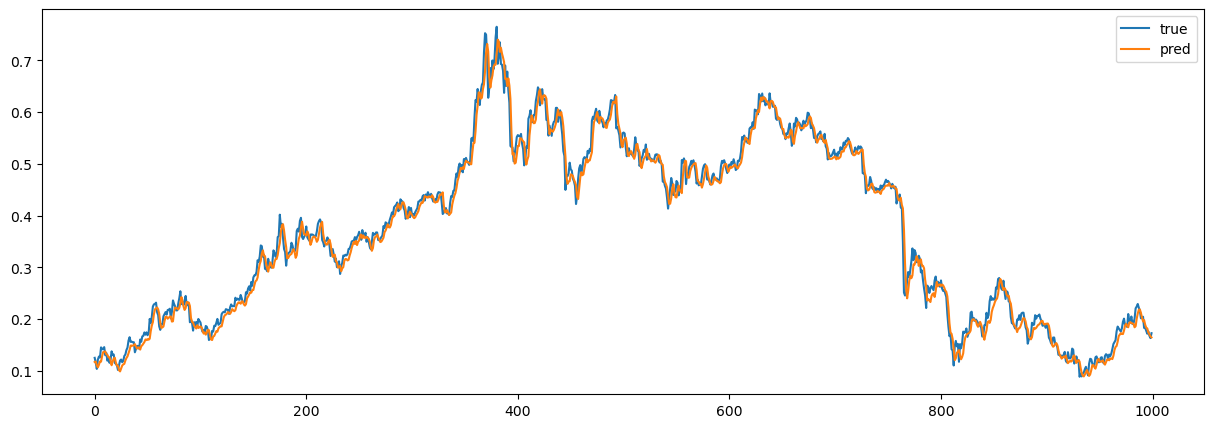

0.00034589469315986465


In [77]:
import matplotlib.pyplot as plt

def evaluate(data, label):
    fig = plt.figure(figsize = (15,5))
    plt.plot(label, label="true")
    preds = model.predict(data)
    plt.plot(preds, label="pred")
    plt.legend()
    plt.show()
    
    print(np.mean((preds - label)**2))

evaluate(train_data[0][:1000], train_data[1][:1000])

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 167.28it/s]


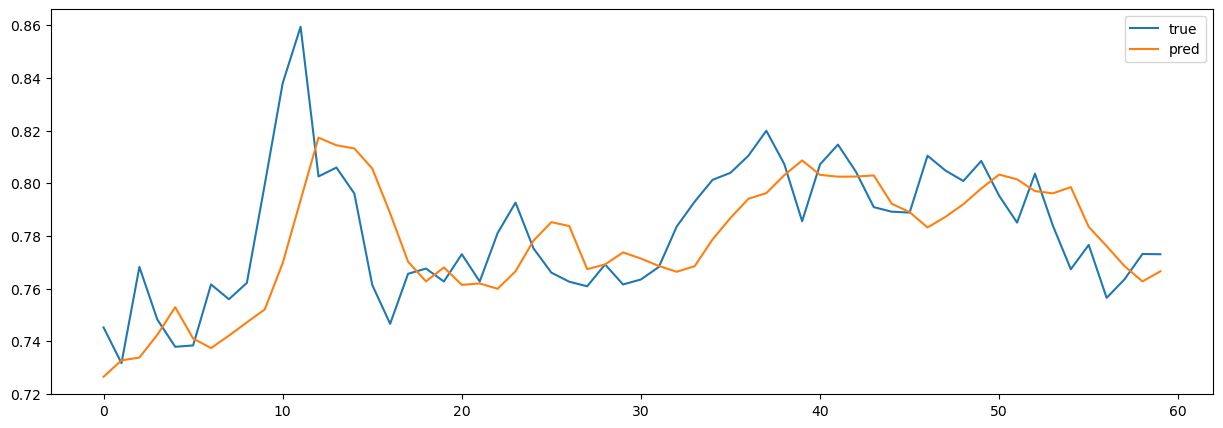

0.000458675178979043


In [80]:
evaluate(test_data[0][:60], test_data[1][:60])

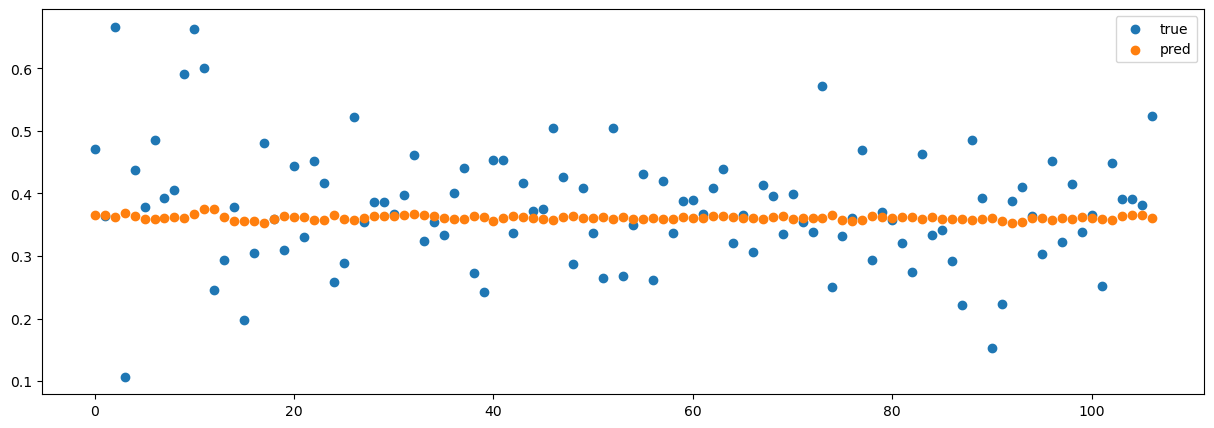

In [57]:
import numpy as np

def sigmoid(x):
    s = 1 / (1 + np.exp(-x))
    return s

import matplotlib.pyplot as plt
fig = plt.figure(figsize = (15,5))
plt.scatter(np.arange(len(preds)), test_data[1], label="true")
plt.scatter(np.arange(len(preds)), preds, label="pred")
# plt.scatter(np.arange(len(preds)), (sigmoid(preds)+0.5).astype('int'), label="pred")
plt.legend()
plt.show()

In [23]:
test_data[1]

array([1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0],
      dtype=int64)

In [22]:
(sigmoid(preds)+0.5).astype('int')

array([0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [21]:
test_data[1] == preds

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False])

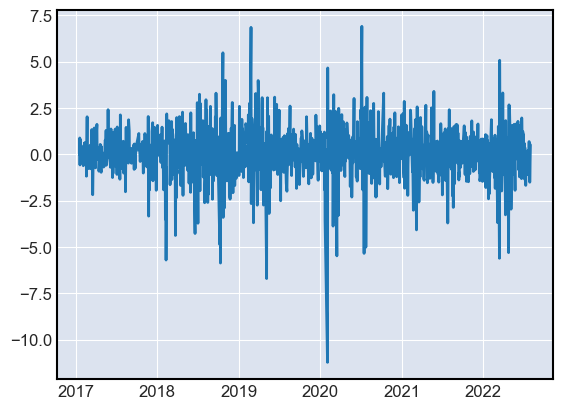

In [40]:
plt.plot(df_stockload["close_change"])

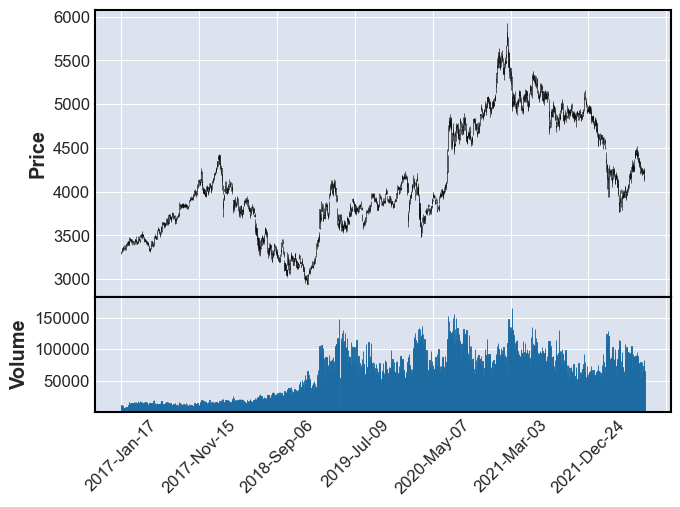

In [39]:
import mplfinance as mpf 

df_stockload = dfs["IF0.cffex"]
df_stockload.index = pd.to_datetime(df_stockload['datetime'])

mpf.plot(df_stockload,type='candle', volume=True)

In [15]:
from sklearn.ensemble import RandomForestClassifier

In [17]:
clf_train_x, clf_train_y = train_data[0].reshape(len(train_data[0]),-1), train_data[1]

In [18]:
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(clf_train_x, clf_train_y)

RandomForestClassifier(max_depth=2, random_state=0)

In [19]:
clf.predict(test_data[0].reshape(len(test_data[0]),-1))

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int64)

In [21]:
(sigmoid(preds)+0.5).astype('int')

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [22]:
test_data[1]

array([1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0],
      dtype=int64)